In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

In [2]:
## This method is for determening outliers
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_ouliers = Q3 + 1.5 * IQR
    lower_outliers = Q1 - 1.5 * IQR
    outliers = series[(series < lower_outliers) | (series > upper_ouliers)]
    return len(outliers)

## Content of the tables
### Chemicals table - all of the concentration of the specific chemical, code for the sensor, amount of water(all the data is from 2023)
### Merged_oxygen table - the code of the sensor(it is either 01/07, but it is the same sensor), amount of oxygen, start time, end time(data from 2021)


In [3]:
ammonium = pd.read_parquet('data/Chemical measurements influent 2023_2024/ammonium_2024.parquet')
ammonium['datumBeginMeting'] = pd.to_datetime(ammonium['datumBeginMeting'])
ammonium = ammonium.rename(columns={"hstWaarde": "hstWaarde_ammonium_2023", "historianTagnummer": "historianTagnummer_ammonium"}).reset_index(drop=True)
ammonium['hstWaarde_ammonium_2023'] = ammonium['hstWaarde_ammonium_2023'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  43282


{'whiskers': [<matplotlib.lines.Line2D at 0x7f543bbd7ce0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f543bba0320>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f543bbd76b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f543bba08f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f543bba0bf0>],
 'means': []}

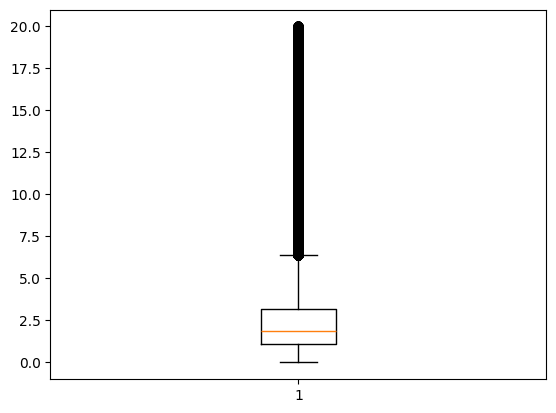

In [4]:
outliers_count = count_outliers_iqr(ammonium['hstWaarde_ammonium_2023'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(ammonium['hstWaarde_ammonium_2023'])

In [5]:
nitrate = pd.read_parquet('data/Chemical measurements influent 2023_2024/nitrate_2024.parquet')
nitrate['datumBeginMeting'] = pd.to_datetime(nitrate['datumBeginMeting'])
nitrate = nitrate.rename(columns={"hstWaarde": "hstWaarde_nitrate", "historianTagnummer": "historianTagnummer_nitrate"}).reset_index(drop=True)
nitrate['hstWaarde_nitrate'] = nitrate['hstWaarde_nitrate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f543aeed3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f543aeed9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f543aeed100>],
 'medians': [<matplotlib.lines.Line2D at 0x7f543aeedf40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f543aeee1b0>],
 'means': []}

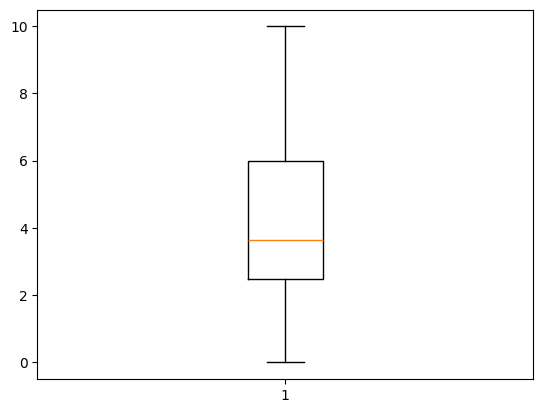

In [6]:
outliers_count = count_outliers_iqr(nitrate['hstWaarde_nitrate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(nitrate['hstWaarde_nitrate'])

In [7]:
phosphate = pd.read_parquet('data/Chemical measurements influent 2023_2024/phosphate_2024.parquet')
phosphate['datumBeginMeting'] = pd.to_datetime(phosphate['datumBeginMeting'])
phosphate = phosphate.rename(columns={"hstWaarde": "hstWaarde_phosphate", "historianTagnummer": "historianTagnummer_phosphate"}).reset_index(drop=True)
phosphate['hstWaarde_phosphate'] = phosphate['hstWaarde_phosphate'].apply(pd.to_numeric, errors='coerce')

Number of outliers:  21886


{'whiskers': [<matplotlib.lines.Line2D at 0x7f543ad0eff0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f543ad0f5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f543ad0ee40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f543ad0fad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f543ad0fda0>],
 'means': []}

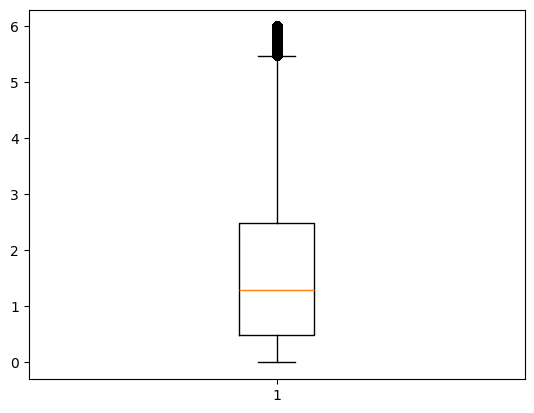

In [8]:
outliers_count = count_outliers_iqr(phosphate['hstWaarde_phosphate'])
print(f"Number of outliers:  {outliers_count}")
plt.boxplot(phosphate['hstWaarde_phosphate'])

In [9]:
merged = pd.merge(ammonium, nitrate, on="datumBeginMeting")
chemicals = pd.merge(merged, phosphate, on="datumBeginMeting")
chemicals_hourly = pd.DataFrame({
    'Hour': chemicals['datumBeginMeting'].dt.floor('h'),  # Hour column for grouping
    'ammonium': chemicals['hstWaarde_ammonium_2023'],
    'nitrate': chemicals['hstWaarde_nitrate'],
    'phosphate': chemicals['hstWaarde_phosphate']
})

chemicals_hourly = chemicals_hourly.dropna(subset=['ammonium', 'nitrate', 'phosphate'], how='all')

imputer = SimpleImputer(strategy='median')
chemicals_imputed = pd.DataFrame(
    imputer.fit_transform(chemicals_hourly[['ammonium', 'nitrate', 'phosphate']]),
    columns=['ammonium', 'nitrate', 'phosphate']
)

log_transformed = np.log1p(chemicals_imputed)

scaler = RobustScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(log_transformed),
    columns=['ammonium', 'nitrate', 'phosphate']
)

chemicals_hourly_scaled = pd.concat([chemicals_hourly[['Hour']].reset_index(drop=True), scaled], axis=1)

hourly_scaled_means = chemicals_hourly_scaled.groupby('Hour').mean().reset_index()

hourly_scaled_means

,Hour,ammonium,nitrate,phosphate
0,2023-01-01 00:00:00,-0.507080,0.222891,-0.966821
1,2023-01-01 01:00:00,-0.000955,-0.191302,-0.601943
2,2023-01-01 02:00:00,-0.025057,-0.094196,-0.796913
3,2023-01-01 03:00:00,-0.603618,-0.268907,-0.805918
4,2023-01-01 04:00:00,-0.721524,-0.418137,-0.850817
...,...,...,...,...
8751,2023-12-31 19:00:00,0.321560,1.207393,-0.501259
8752,2023-12-31 20:00:00,0.506687,1.233421,-0.623417
8753,2023-12-31 21:00:00,-0.097767,1.152491,-0.824112
8754,2023-12-31 22:00:00,-0.092486,1.188603,-0.807678


In [10]:
oxygen_a = pd.read_parquet('data/OxygenData2024/oxygen_a_2024.parquet')
oxygen_a = oxygen_a.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_a = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofA_EDE_B121069901_K600.MTW.parquet')
oxygen_a = oxygen_a.rename(columns={"hstWaarde": "hstWaarde_oxygen_a", "historianTagnummer": "historianTagnummer_oxygen_a"}).reset_index(drop=True)
oxygen_a['hstWaarde_oxygen_a'] = oxygen_a['hstWaarde_oxygen_a'].apply(pd.to_numeric, errors='coerce')

oxygen_b = pd.read_parquet('data/OxygenData2024/oxygen_b_2024.parquet')
oxygen_b = oxygen_b.drop(columns=['waardebewerkingsmethodeCode'])
legacy_oxygen_b = pd.read_parquet('data/HistoricalWWTPData/DTWINTERNALWWTPDATA/Oxygen Data/zuurstofB_EDE_B121069907_K600.MTW.parquet')
oxygen_b = oxygen_b.rename(columns={"hstWaarde": "hstWaarde_oxygen_b", "historianTagnummer": "historianTagnummer_oxygen_b"}).reset_index(drop=True)
oxygen_b['hstWaarde_oxygen_b'] = oxygen_b['hstWaarde_oxygen_b'].apply(pd.to_numeric, errors='coerce')

In [11]:
combines_oxygen = pd.concat([oxygen_a, oxygen_b], axis=1)
combines_oxygen['Average_value'] = (combines_oxygen['hstWaarde_oxygen_a'] + combines_oxygen['hstWaarde_oxygen_b']) / 2
combines_oxygen

,historianTagnummer_oxygen_a,hstWaarde_oxygen_a,datumBeginMeting,datumEindeMeting,historianTagnummer_oxygen_b,hstWaarde_oxygen_b,datumBeginMeting,datumEindeMeting,Average_value
0,EDE_B121069901_K600.MTW,1.663,2023-01-01 00:00:00,2023-01-01 00:01:00,EDE_B121069907_K600.MTW,0.777,2023-01-01 00:00:00,2023-01-01 00:01:00,1.2200
1,EDE_B121069901_K600.MTW,1.789,2023-01-01 00:01:00,2023-01-01 00:02:00,EDE_B121069907_K600.MTW,0.982,2023-01-01 00:01:00,2023-01-01 00:02:00,1.3855
2,EDE_B121069901_K600.MTW,2.105,2023-01-01 00:02:00,2023-01-01 00:03:00,EDE_B121069907_K600.MTW,1.189,2023-01-01 00:02:00,2023-01-01 00:03:00,1.6470
3,EDE_B121069901_K600.MTW,2.271,2023-01-01 00:03:00,2023-01-01 00:04:00,EDE_B121069907_K600.MTW,1.266,2023-01-01 00:03:00,2023-01-01 00:04:00,1.7685
4,EDE_B121069901_K600.MTW,2.168,2023-01-01 00:04:00,2023-01-01 00:05:00,EDE_B121069907_K600.MTW,1.403,2023-01-01 00:04:00,2023-01-01 00:05:00,1.7855
...,...,...,...,...,...,...,...,...,...
525044,EDE_B121069901_K600.MTW,1.635,2023-12-31 23:55:00,2023-12-31 23:56:00,EDE_B121069907_K600.MTW,0.596,2023-12-31 23:55:00,2023-12-31 23:56:00,1.1155
525045,EDE_B121069901_K600.MTW,1.841,2023-12-31 23:56:00,2023-12-31 23:57:00,EDE_B121069907_K600.MTW,0.726,2023-12-31 23:56:00,2023-12-31 23:57:00,1.2835
525046,EDE_B121069901_K600.MTW,1.816,2023-12-31 23:57:00,2023-12-31 23:58:00,EDE_B121069907_K600.MTW,0.843,2023-12-31 23:57:00,2023-12-31 23:58:00,1.3295
525047,EDE_B121069901_K600.MTW,1.812,2023-12-31 23:58:00,2023-12-31 23:59:00,EDE_B121069907_K600.MTW,0.880,2023-12-31 23:58:00,2023-12-31 23:59:00,1.3460


In [12]:
weather = pd.read_csv('weather.csv')
weather = weather.rename(columns={'Timestamp': 'Hour'})
weather['Hour'] = pd.to_datetime(weather['Hour'])
weather

,Hour,Station,WindDirection,WindSpeedMean_10min,WindSpeedLast10Min,WindGustMax,Temperature,MinTemp_10cm_6hr,DewPointTemp,SunshineDuration,...,Visibility,CloudCover,RelativeHumidity,WeatherCode,WeatherCodeIndicator,Fog,Rain,Snow,Thunder,IceFormation
0,2023-01-01 00:00:00,275,220,100,90,150,153,,76,0,...,82,8,59,23,7,0,1,0,0,0
1,2023-01-01 01:00:00,275,220,100,90,170,146,,77,0,...,83,8,63,81,7,0,1,0,0,0
2,2023-01-01 02:00:00,275,210,90,90,140,150,,67,0,...,83,8,57,23,7,0,1,0,0,0
3,2023-01-01 03:00:00,275,220,90,90,150,147,,64,0,...,83,8,57,,5,0,0,0,0,0
4,2023-01-01 04:00:00,275,240,80,70,180,141,,72,0,...,83,8,63,23,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,275,200,60,70,110,81,,46,0,...,62,8,78,51,7,0,1,0,0,0
8756,2023-12-31 20:00:00,275,200,80,70,130,82,,47,0,...,72,8,78,81,7,0,1,0,0,0
8757,2023-12-31 21:00:00,275,200,80,90,140,85,,43,0,...,75,8,74,81,7,0,1,0,0,0
8758,2023-12-31 22:00:00,275,200,80,80,130,83,,42,0,...,75,7,75,23,7,0,1,0,0,0


In [13]:
combined = pd.merge(chemicals_hourly_scaled, weather, on='Hour', how='inner')
combined

,Hour,ammonium,nitrate,phosphate,Station,WindDirection,WindSpeedMean_10min,WindSpeedLast10Min,WindGustMax,Temperature,...,Visibility,CloudCover,RelativeHumidity,WeatherCode,WeatherCodeIndicator,Fog,Rain,Snow,Thunder,IceFormation
0,2023-01-01 00:00:00,-0.326097,0.302781,-0.969689,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
1,2023-01-01 00:00:00,-0.362965,0.302781,-0.969689,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
2,2023-01-01 00:00:00,-0.407329,0.302781,-0.970863,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
3,2023-01-01 00:00:00,-0.407982,0.288969,-0.970863,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
4,2023-01-01 00:00:00,-0.409290,0.271195,-0.970863,275,220,100,90,150,153,...,82,8,59,23,7,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525404,2023-12-31 23:00:00,-0.110140,1.088163,-0.796582,275,200,80,90,150,86,...,75,8,72,3,7,0,0,0,0,0
525405,2023-12-31 23:00:00,-0.122385,1.108667,-0.818035,275,200,80,90,150,86,...,75,8,72,3,7,0,0,0,0,0
525406,2023-12-31 23:00:00,-0.134737,1.110659,-0.862153,275,200,80,90,150,86,...,75,8,72,3,7,0,0,0,0,0
525407,2023-12-31 23:00:00,-0.147196,1.112790,-0.863224,275,200,80,90,150,86,...,75,8,72,3,7,0,0,0,0,0


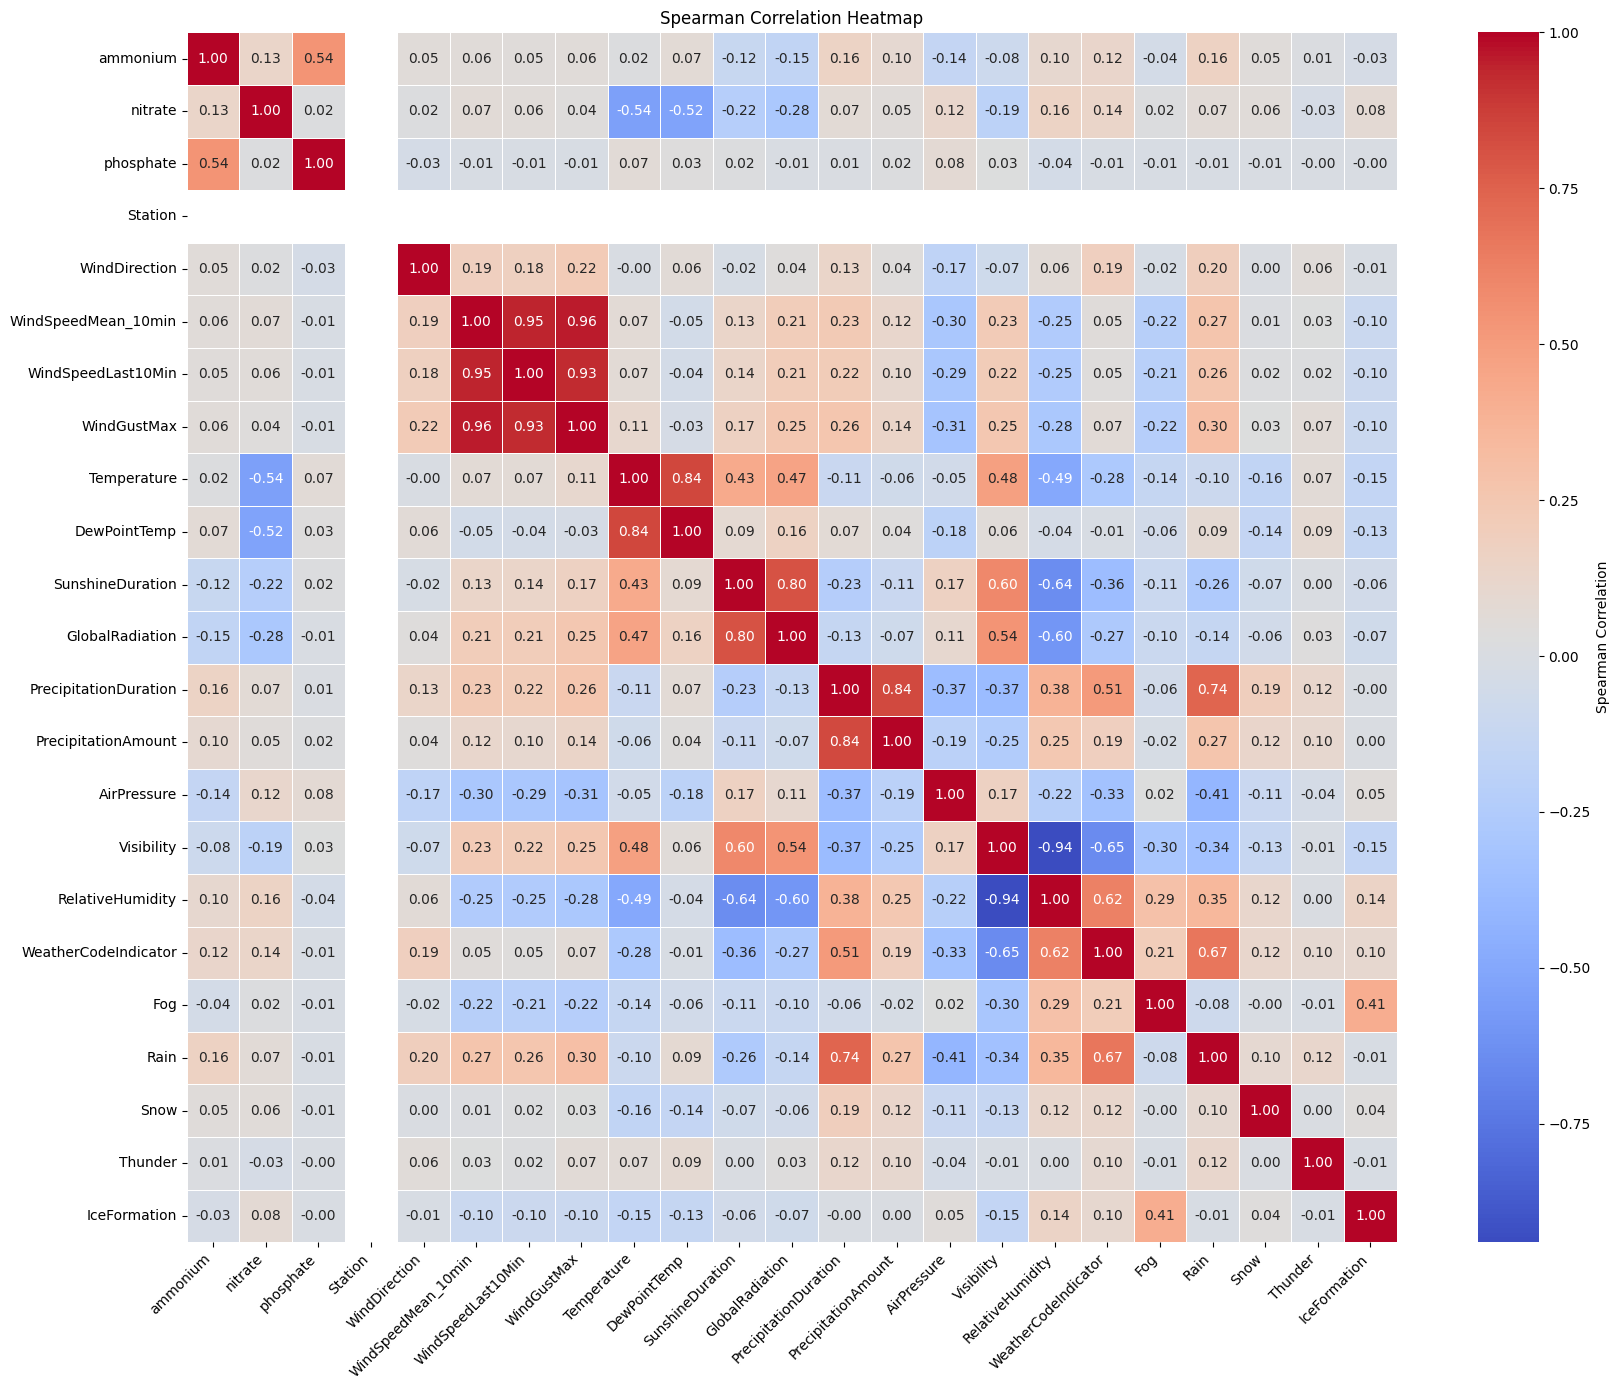

In [24]:
numeric_data = combined.select_dtypes(include='number')
spearman_corr = numeric_data.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    spearman_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Spearman Correlation"}
)
plt.title("Spearman Correlation Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41949/4081920338.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")


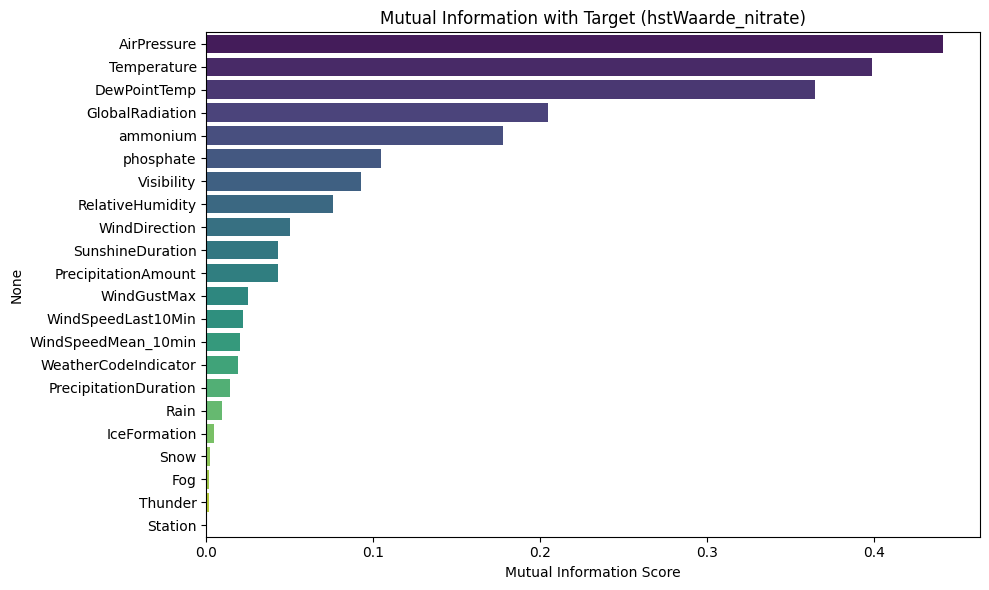

In [14]:
from sklearn.feature_selection import mutual_info_regression

# Example: measure mutual information with respect to a target
target = 'nitrate'
X = combined.drop(columns=[target])
X = X.select_dtypes(include=['int64', 'float64']) 
y = combined[target]

mi = mutual_info_regression(X, y, discrete_features=False)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_scores.values, y=mi_scores.index, palette="viridis")
plt.title("Mutual Information with Target (hstWaarde_nitrate)")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()

In [16]:
target = 'nitrate'
features = ['DewPointTemp', 'AirPressure', 'Temperature']
X = combined[features]
y = combined[target]

In [17]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [18]:
num_imputer = SimpleImputer(strategy='median')
X_num = num_imputer.fit_transform(X[numerical_features])

In [19]:
scaler = RobustScaler()
X_num_scaled = scaler.fit_transform(X_num)

In [20]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X[categorical_features])

In [26]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
model = Pipeline(steps=[
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [33]:
cv_scores = cross_val_score(
    model,
    X,   # already-numeric feature matrix
    y,
    cv=kf,
    scoring='r2'
)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [36]:
print("Fold-by-fold R²:", cv_scores)
print("Average R²      :", np.mean(cv_scores))
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error MSE: ", mse)

Fold-by-fold R²: [0.92084951 0.92058146 0.92094957 0.92002534 0.92032044]
Average R²      : 0.9205452633117466
Mean Squared Error MSE:  0.0337608597184516
